# Calibration of the flooding model

## Abstract

The goal of this example is to present the statistical hypotheses of the calibration of the flooding model. More precisely, this example shows how the observations in the "calibration-flooding-observations.csv" were generated.

## Model

The simulator predicts the water height H depending on the flowrate Q.

We consider the following four variable:

* Q : the river flowrate ($m^3/s$)
* Ks : the Strickler coefficient ($m^{1/3}/s$)
* Zv : the downstream riverbed level (m)
* Zm : the upstream riverbed level (m)

When the Strickler coefficient increases, the riverbed generates less friction to the water flow.

## Parameters

We consider the following parameters:

* the length of the river L = 5000 (m),
* the width of the river B = 300 (m).

## Outputs

We make the hypothesis that the slope of the river is nonpositive and close to zero, which implies: 
$$
\alpha = \frac{Z_m - Z_v}{L},
$$
if $Z_m \geq Z_v$. 
The height of the river is:
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$
for any $K_s, Q>0$.

<img src="river_section_adjusted_light.png" width="400" />

## Distribution

We assume that the river flowrate has the following truncated Gumbel distribution:

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|

## Parameters to calibrate

The variables to calibrate are $(Kz,Zv,Zm)$ and are set to the following values:
$$
Ks = 30, \qquad Zv = 50, \qquad Zm = 55.
$$

## Observations

In this section, we describe the statistical model associated with the $n$ observations.
The errors of the water heights are associated with a gaussian distribution with a zero mean and a standard variation equal to:
$$
\sigma=0.1.
$$
Therefore, the observed water heights are:
$$
H_i = G(Q_i,Ks,Zv,Zm) + \epsilon
$$
for $i=1,...,n$ where
$$
\epsilon \sim \mathcal{N}(0,\sigma^2).
$$
We consider a sample size equal to:
$$
n=100.
$$
The observations are the couples $(Q,H)$.

## Analysis

In this model, the variables $Z_m$ and $Z_v$ are not identifiables, since only the difference $Z_m-Z_v$ matters. Hence, calibrating this model requires some regularization.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

We define the function $G$.

In [2]:
def functionFlooding(X) :
    L = 5.0e3
    B = 300.0
    Q, K_s, Z_v, Z_m = X
    alpha = (Z_m - Z_v)/L
    H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

In [3]:
g = ot.PythonFunction(4, 1, functionFlooding) 
g = ot.MemoizeFunction(g)
g.setOutputDescription(["H (m)"])

Create the output random vector.

In [4]:
Qparam = ot.GumbelAB(1013., 558.)
Q = ot.ParametrizedDistribution(Qparam)
Q = ot.TruncatedDistribution(Q,ot.TruncatedDistribution.LOWER)
Q.setDescription(["Q (m3/s)"])
Q

class=TruncatedDistribution name=TruncatedDistribution distribution=class=ParametrizedDistribution parameters=class=GumbelAB name=Unnamed a=1013 b=558 distribution=class=Gumbel name=Gumbel dimension=1 alpha=0.00179211 beta=1013 bounds=class=Interval name=Unnamed dimension=1 lower bound=class=Point name=Unnamed dimension=1 values=[0] upper bound=class=Point name=Unnamed dimension=1 values=[19000.8] finite lower bound=[1] finite upper bound=[0] thresholdRealization=0.5

Set the parameters to be calibrated.

In [5]:
K_s = ot.Dirac(30.0)
Z_v = ot.Dirac(50.0)
Z_m = ot.Dirac(55.0)
K_s.setDescription(["Ks (m^(1/3)/s)"])
Z_v.setDescription(["Zv (m)"])
Z_m.setDescription(["Zm (m)"])

Create the joint input distribution.

In [6]:
inputRandomVector = ot.ComposedDistribution([Q, K_s, Z_v, Z_m])

Create a Monte-Carlo sample of the output H.

In [7]:
sampleSize = 100
inputSample = inputRandomVector.getSample(sampleSize)
outputH = g(inputSample)

Observe the distribution of the output H.

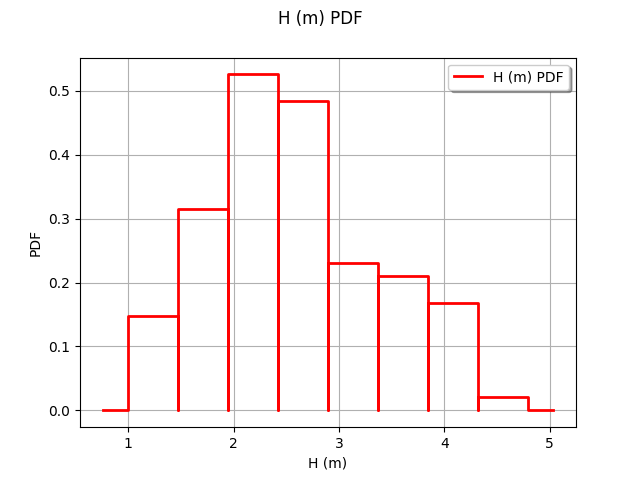

In [8]:
ot.HistogramFactory().build(outputH).drawPDF()

Generate the observation noise and add it to the output of the model.

In [9]:
sigmaObservationNoiseH = 0.1 # (m)
noiseH = ot.Normal(0.,sigmaObservationNoiseH)
sampleNoiseH = noiseH.getSample(sampleSize)
observedH = outputH + sampleNoiseH

Plot the Y observations versus the X observations.

In [10]:
observedQ = inputSample[:,0]

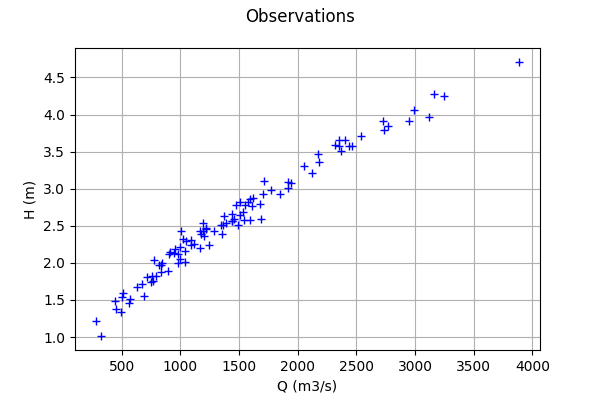

In [11]:
graph = ot.Graph("Observations","Q (m3/s)","H (m)",True)
cloud = ot.Cloud(observedQ,observedH)
graph.add(cloud)
graph

Save the observations into a file.

In [12]:
observedSample = ot.Sample(sampleSize,2)
observedSample.setDescription(["Q (m3/s)","H (m)"])
observedSample[:,0] = observedQ[:]
observedSample[:,1] = observedH[:]
#observedSample.exportToCSVFile("calibration-flooding-observations.csv")